# ARIMA


In [91]:
# Load the saved model and make predictions on the test data    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [92]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    # Convert 'date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    #df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [93]:
# Load in the train and test data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

# Concatenate the train and test data
df = pd.concat([train_df, test_df])
df['Date'] = pd.to_datetime(df['Date'])

df

,Date,Day_ahead_price (€/MWh),Solar_radiation (W/m2),Wind_speed (m/s),Temperature (°C),Biomass (GWh),Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),...,Lag_1_day,Lag_2_days,Lag_3_days,Lag_4_days,Lag_5_days,Lag_6_days,Lag_7_days,Day_of_week,Month,Rolling_mean_7
0,2012-01-08,26.83,17.54,5.21,3.74,98.605,189.718,48.467,354.178,256.892,...,32.58,36.26,20.35,32.16,35.03,33.82,18.19,6,1,31.00
1,2012-01-09,47.91,13.04,4.24,3.80,98.605,344.154,49.054,382.756,282.438,...,26.83,32.58,36.26,20.35,32.16,35.03,33.82,0,1,33.02
2,2012-01-10,45.77,28.71,4.30,4.81,98.605,360.126,51.143,334.267,267.311,...,47.91,26.83,32.58,36.26,20.35,32.16,35.03,1,1,34.55
3,2012-01-11,47.83,21.58,4.08,5.14,98.605,360.330,50.693,385.000,277.343,...,45.77,47.91,26.83,32.58,36.26,20.35,32.16,2,1,36.79
4,2012-01-12,43.10,25.12,6.77,4.98,98.605,306.521,50.732,332.985,266.820,...,47.83,45.77,47.91,26.83,32.58,36.26,20.35,3,1,40.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,2024-07-24,66.61,225.04,3.47,17.54,110.007,43.469,85.857,199.246,194.291,...,79.62,88.75,58.45,59.32,86.47,90.75,76.79,2,7,75.71
755,2024-07-25,78.34,272.71,2.12,17.85,110.410,50.676,82.632,195.983,209.610,...,66.61,79.62,88.75,58.45,59.32,86.47,90.75,3,7,73.94
756,2024-07-26,93.04,172.33,2.60,19.09,110.852,42.333,79.531,205.273,205.773,...,78.34,66.61,79.62,88.75,58.45,59.32,86.47,4,7,74.88
757,2024-07-27,80.74,176.67,2.05,19.63,110.479,33.307,74.958,184.012,216.412,...,93.04,78.34,66.61,79.62,88.75,58.45,59.32,5,7,77.94


In [94]:
# Define the target column
target_column = "Oil_price (EUR)"

In [95]:
df.columns

Index(['Date', 'Day_ahead_price (€/MWh)', 'Solar_radiation (W/m2)',
       'Wind_speed (m/s)', 'Temperature (°C)', 'Biomass (GWh)',
       'Hard_coal (GWh)', 'Hydro (GWh)', 'Lignite (GWh)', 'Natural_gas (GWh)',
       'Other (GWh)', 'Pumped_storage_generation (GWh)', 'Solar_energy (GWh)',
       'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
       'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
       'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)', 'Lag_1_day',
       'Lag_2_days', 'Lag_3_days', 'Lag_4_days', 'Lag_5_days', 'Lag_6_days',
       'Lag_7_days', 'Day_of_week', 'Month', 'Rolling_mean_7'],
      dtype='object')

Text(0, 0.5, 'OIL Price (€/MWh)')

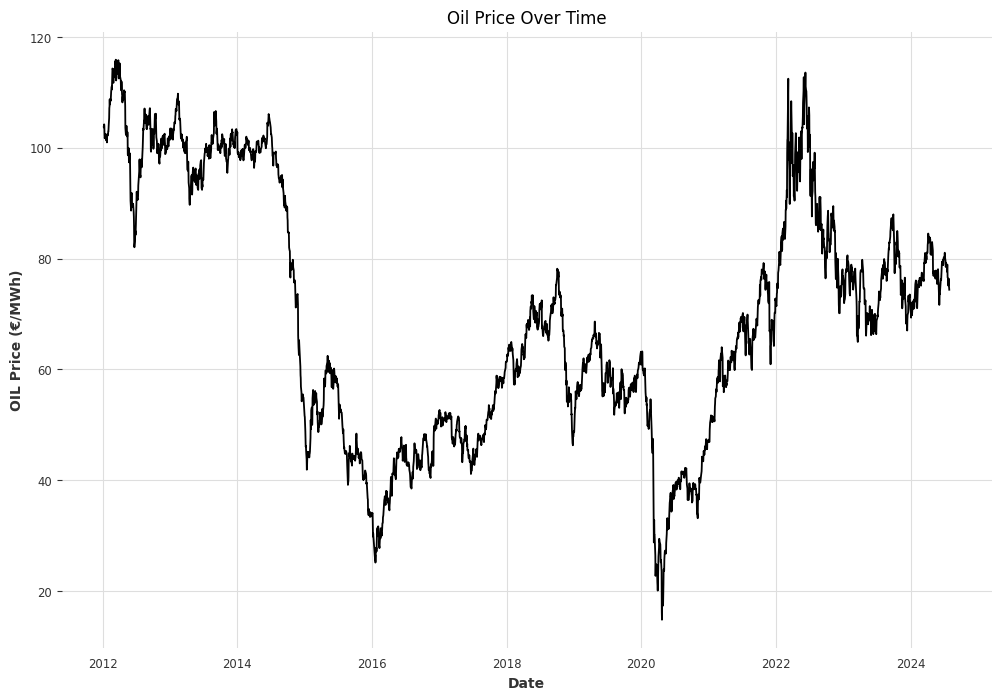

In [96]:
# plot the "Oil_price" column over time
plt.figure(figsize=(12, 8))
plt.plot(df['Date'], df["Oil_price (EUR)"])
plt.title('Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('OIL Price (€/MWh)')



Text(0, 0.5, 'OIL Price (€/MWh)')

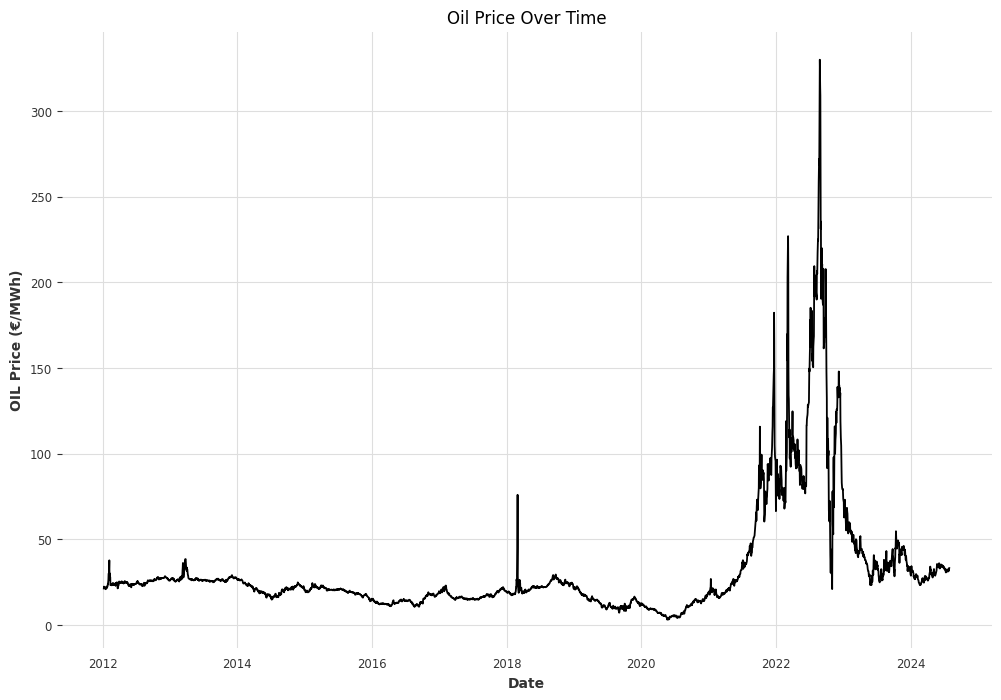

In [97]:
# plot the "Oil_price" column over time
plt.figure(figsize=(12, 8))
plt.plot(df['Date'], df[target_column])
plt.title(f'{target_column}')
plt.xlabel('Date')
plt.ylabel(f'{target_column})

In [98]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df[target_column])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.0681613758987787
p-value: 0.25750823282667745


In [99]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, crit_values = kpss(df[target_column])
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)


KPSS Statistic: 2.2282316123770785
p-value: 0.01


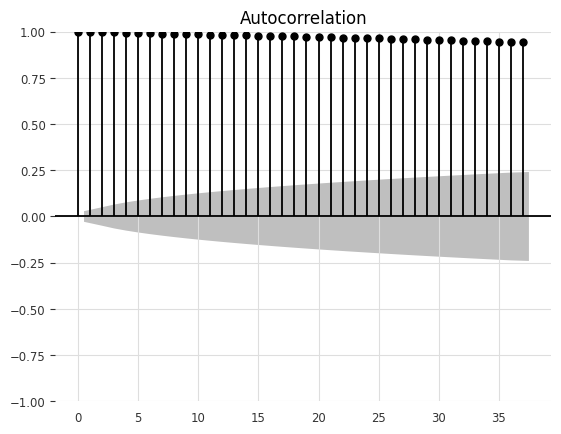

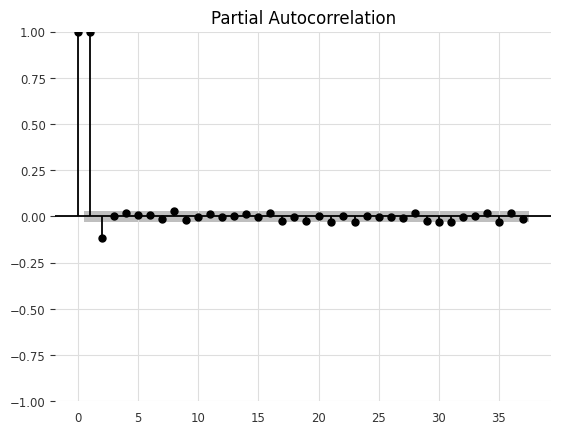

In [100]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' contains your time series data
plot_acf(df[target_column])
plt.show()

plot_pacf(df[target_column])
plt.show()


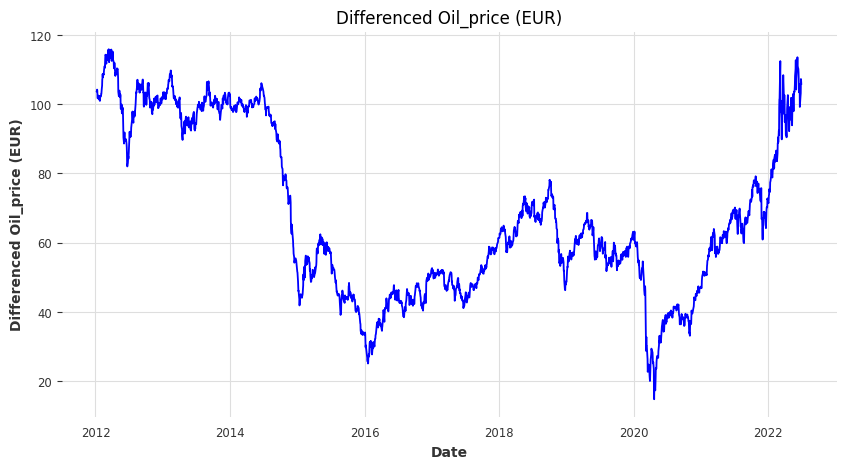

ADF Statistic: -14.735556214123818
p-value: 2.61892264366257e-27
KPSS Statistic: 0.4528304326690264
p-value: 0.05438343419438518


In [101]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load data
file_path = '../../../data/Final_data/train_df.csv'  # Change the path as necessary
df = load_and_prepare_data(file_path)

# Perform first-order differencing on the target variable
df[f'{target_column}_diff'] = df[target_column].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df[target_column], color='blue')
plt.title(f'Differenced {target_column}')
plt.xlabel('Date')
plt.ylabel(f'Differenced {target_column}')
plt.show()

# Perform ADF test on differenced data
adf_result = adfuller(df[f'{target_column}_diff'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Perform KPSS test on differenced data
kpss_stat, p_value, lags, crit_values = kpss(df[f'{target_column}_diff'].dropna())
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)


## Autoarima

In [ ]:
from darts.models import AutoARIMA
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import pandas as pd
import plotly.graph_objects as go
from darts.metrics import mape, mae, rmse, mse

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load target and covariate data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

df = pd.concat([train_df, test_df])

# Create target TimeSeries
series_train = TimeSeries.from_dataframe(train_df, 'Date', target_column).astype('float32')
series_test = TimeSeries.from_dataframe(test_df, 'Date', target_column).astype('float32')

# Convert covariates to TimeSeries
#covariates_train = TimeSeries.from_dataframe(train_df, 'Date', future_covariates_columns_2).astype('float32')
#covariates_test = TimeSeries.from_dataframe(test_df, 'Date', future_covariates_columns_2).astype('float32')

# Scale both target and covariates
scaler_target = Scaler()
scaler_covariates = Scaler()

series_train_scaled = scaler_target.fit_transform(series_train)
#covariates_train_scaled = scaler_covariates.fit_transform(covariates_train)
series_test_scaled = scaler_target.transform(series_test)
#covariates_test_scaled = scaler_covariates.transform(covariates_test)

# Initialize AutoARIMA model
model = AutoARIMA(
    start_p=1,
    start_q=1,
    max_p=7,
    max_q=7,
    d=None,
    seasonal=True,
    m=365,  # Adjust as necessary
    start_P=0,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

# Fit the model with covariates
model.fit(series_train_scaled)

# Forecast with covariates
n = len(series_test_scaled)
forecast_scaled = model.predict(n=n)

# Inverse transform the forecast
forecast = scaler_target.inverse_transform(forecast_scaled)
test_series = scaler_target.inverse_transform(series_test_scaled)

# Plot the actual vs forecasted data
fig = go.Figure()

# Add actual test data
fig.add_trace(go.Scatter(x=test_series.time_index,
                         y=test_series.values().squeeze(),
                         mode='lines', name='Actual', line=dict(color='blue')))

# Add forecasted data
fig.add_trace(go.Scatter(x=forecast.time_index,
                         y=forecast.values().squeeze(),
                         mode='lines', name='Forecast', line=dict(color='red')))

# Update layout
fig.update_layout(title='AutoARIMA Model - Forecast with Covariates',
                  xaxis_title='Date', yaxis_title=f'{target_column}',
                  legend=dict(x=1, y=1, xanchor='right', yanchor='top', bordercolor='black', borderwidth=1),
                  template='plotly_white')

# Save the plot as a PNG image
plot_path = f"autoarima_forecast_plot_{target_column}.png"
fig.write_image(plot_path)
print(f"Forecast plot saved at: {plot_path}")

# Calculate error metrics
mape_value = mape(test_series, forecast)
mae_value = mae(test_series, forecast)
rmse_value = rmse(test_series, forecast)
mse_value = mse(test_series, forecast)

# Print error metrics
print('Error Metrics on Test Set:')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%')
print(f'Mean Absolute Error (MAE): {mae_value:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value:.2f}')
print(f'Mean Squared Error (MSE): {mse_value:.2f}')

# Save error metrics to CSV
metrics_path = "autoarima_error_metrics.csv"
metrics_df = pd.DataFrame({
    "Metric": ["MAPE", "MAE", "RMSE", "MSE"],
    "Value": [mape_value, mae_value, rmse_value, mse_value]
})
metrics_df.to_csv(metrics_path, index=False)
print(f"Error metrics saved at: {metrics_path}")


Performing stepwise search to minimize aic


# Prophet


12:08:17 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



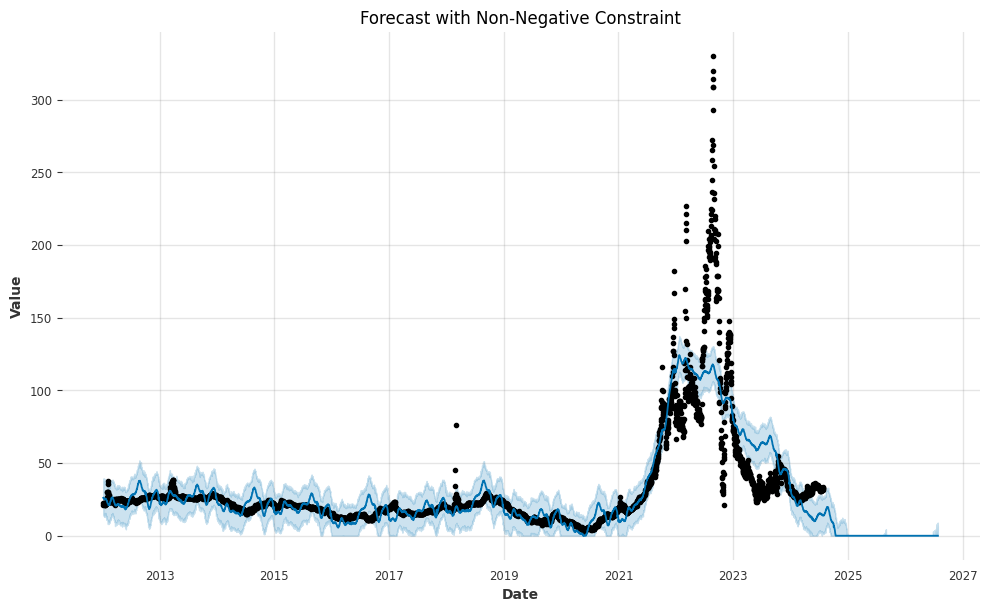

In [74]:
from prophet import Prophet
import pandas as pd
import numpy as np
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_squared_error

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load target data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

# Concatenate the train and test data
prophet_df = pd.concat([train_df, test_df])
prophet_df = prophet_df[['Date', target_column]].rename(columns={'Date': 'ds', target_column: 'y'})

# Set a floor of 0 to prevent negative values in the forecast
prophet_df['floor'] = 10

# Initialize and fit the model with floor set to 0
m = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    changepoint_prior_scale=0.5, 
    holidays_prior_scale=5,
    seasonality_prior_scale=5,
    interval_width=0.5,
)

# Add holidays for Germany
m.add_country_holidays(country_name='DE')

m.fit(prophet_df)

# Create future dataframe and set floor for future data
future = m.make_future_dataframe(periods=730)  # For two years ahead
future['floor'] = 0

# Forecast
forecast = m.predict(future)

# Clip negative values as an additional safeguard
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Plot forecast
fig = m.plot(forecast)
plt.title('Forecast with Non-Negative Constraint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [ ]:
from itertools import product
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

for params in all_params:
    m = Prophet(**params).add_country_holidays(country_name='DE')
    m.fit(prophet_df)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
best_params = all_params[np.argmin(rmses)]


12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:11 - cmdstanpy - INFO - Chain [1] done processing


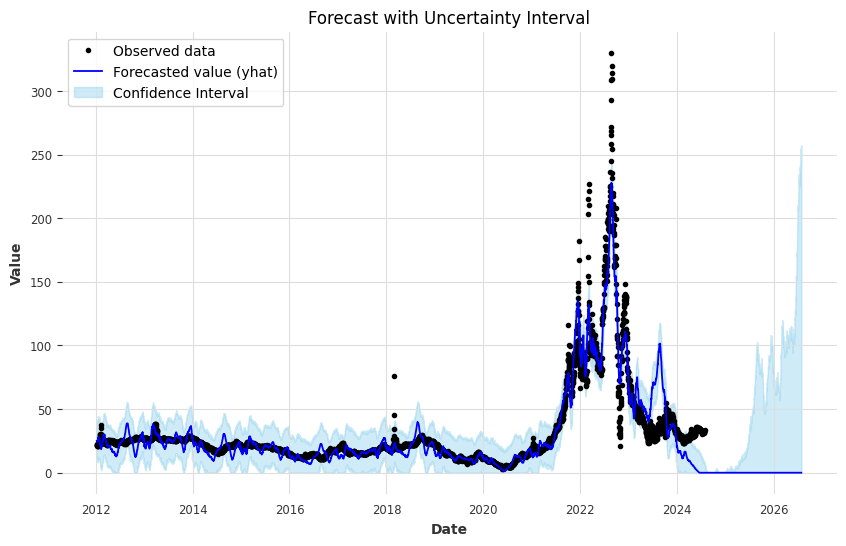

In [71]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

# Concatenate the train and test data
prophet_df = pd.concat([train_df, test_df])
prophet_df = prophet_df[['Date', target_column]].rename(columns={'Date': 'ds', target_column: 'y'})

# Ensure no negative or zero values
prophet_df = prophet_df[prophet_df['y'] > 0]

# Set a more conservative cap for logistic growth
prophet_df['cap'] = prophet_df['y'].max() * 1.2
prophet_df['floor'] = 0

# Initialize the model with more realistic priors
m = Prophet(
    growth='linear',  # Use linear growth for more flexibility
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='multiplicative',  # Multiplicative seasonality
    changepoint_prior_scale=1,  # Reduced for smoother trend
    n_changepoints=25,  # Fewer changepoints for a less complex trend
    seasonality_prior_scale=2,  # Reduced to lessen seasonal influence
    interval_width=0.2,
)

# Add German holidays
m.add_country_holidays(country_name='DE')

# Optionally add custom seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fit the model
m.fit(prophet_df)

# Create future dataframe with floor and cap
future = m.make_future_dataframe(periods=730)
future['cap'] = prophet_df['cap'].iloc[0]
future['floor'] = 0

# Forecast
forecast = m.predict(future)

# Ensure no negative predictions (safeguard)
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Plot forecast with observed data on the original scale
fig, ax = plt.subplots(figsize=(10, 6))

# Plot observed data
ax.plot(prophet_df['ds'], prophet_df['y'], 'k.', label='Observed data')

# Plot forecasted values
ax.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecasted value (yhat)')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                color='skyblue', alpha=0.4, label='Confidence Interval')

# Add legend and labels
ax.legend(loc='upper left', frameon=True)
plt.title('Forecast with Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


## Attempt for the oil price: 

12:14:53 - cmdstanpy - INFO - Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



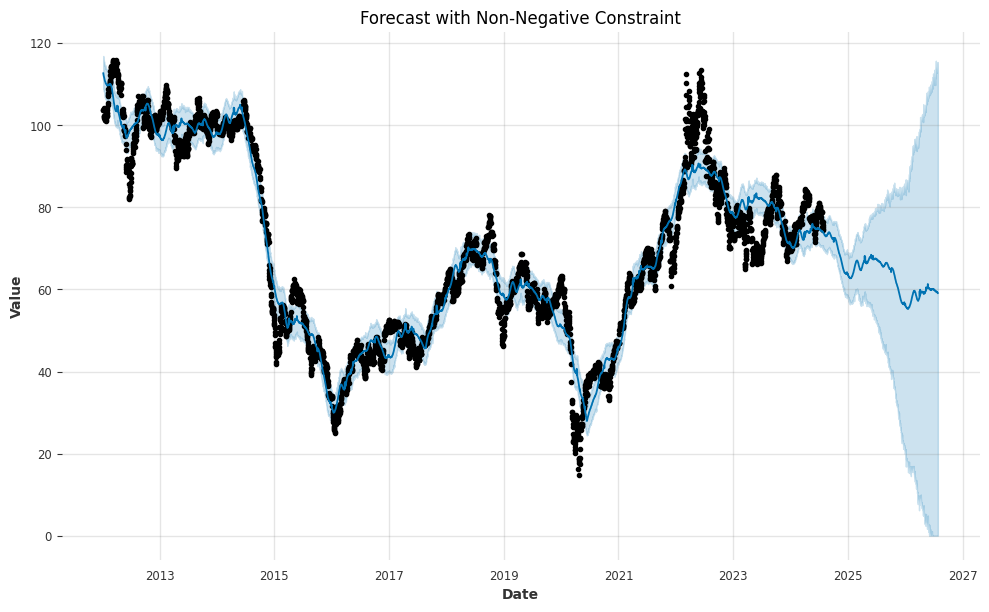

In [84]:
from prophet import Prophet
import pandas as pd
import numpy as np
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_squared_error

target_column = "Oil_price (EUR)"

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load target data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

# Concatenate the train and test data
prophet_df = pd.concat([train_df, test_df])
prophet_df = prophet_df[['Date', target_column]].rename(columns={'Date': 'ds', target_column: 'y'})

# Set a floor of 0 to prevent negative values in the forecast
#prophet_df['floor'] = 0

# Initialize and fit the model with floor set to 0
m = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    changepoint_prior_scale=0.5, 
    holidays_prior_scale=5,
    seasonality_prior_scale=5,
    interval_width=0.5,
)

# Add holidays for Germany
m.add_country_holidays(country_name='DE')

m.fit(prophet_df)

# Create future dataframe and set floor for future data
future = m.make_future_dataframe(periods=730)  # For two years ahead
#future['floor'] = 0

# Forecast
forecast = m.predict(future)

# Clip negative values as an additional safeguard
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Plot forecast
fig = m.plot(forecast)
plt.title('Forecast with Non-Negative Constraint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


12:30:47 - cmdstanpy - INFO - Chain [1] start processing
12:30:47 - cmdstanpy - INFO - Chain [1] done processing
12:30:49 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:52 - cmdstanpy - INFO - Chain [1] done processing
12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing
12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing
12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing
12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1]

Best parameters: {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive', 'interval_width': 0.8}


12:43:30 - cmdstanpy - INFO - Chain [1] start processing
12:43:36 - cmdstanpy - INFO - Chain [1] done processing
/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



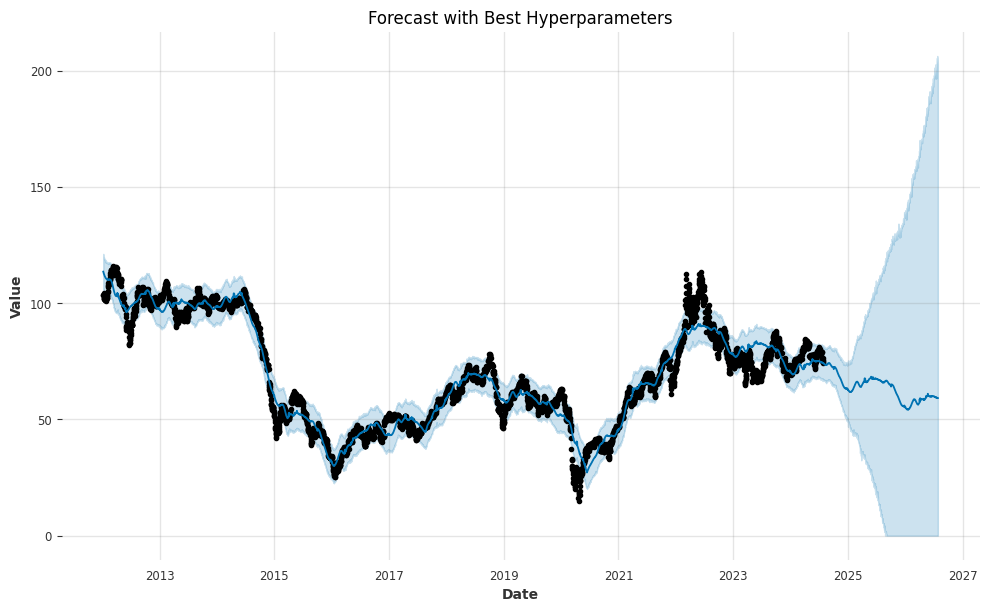

In [88]:
from prophet import Prophet
import pandas as pd
import numpy as np
from itertools import product
from sklearn.metrics import mean_squared_error

target_column = "Oil_price (EUR)"

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load target data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

# Concatenate the train and test data
prophet_df = pd.concat([train_df, test_df])
prophet_df = prophet_df[['Date', target_column]].rename(columns={'Date': 'ds', target_column: 'y'})

# Define parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 5.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'interval_width': [0.8, 0.9, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
errors = []  # Store the RMSE for each params here

# Loop through each parameter combination
for params in all_params:
    # Initialize and fit the model
    m = Prophet(
        seasonality_mode=params['seasonality_mode'],
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        interval_width=params['interval_width']
    )
    m.add_country_holidays(country_name='DE')
    m.fit(prophet_df)

    # Create future dataframe and set floor
    future = m.make_future_dataframe(periods=730)

    # Make forecast
    forecast = m.predict(future)

    # Compute RMSE on the historical period
    y_true = prophet_df['y']
    y_pred = forecast['yhat'][:len(y_true)]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    errors.append(rmse)

# Find the best parameters
best_params = all_params[np.argmin(errors)]
print("Best parameters:", best_params)

# Train the model with the best parameters
m = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    interval_width=best_params['interval_width']
)
m.add_country_holidays(country_name='DE')
m.fit(prophet_df)

# Forecast with the best model
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)

# Clip negative values as an additional safeguard
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Plot forecast
fig = m.plot(forecast)
plt.title('Forecast with Best Hyperparameters')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [87]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascension Day,Ascension Day_lower,Ascension Day_upper,Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-08,119.202280,106.551193,121.243388,119.202280,119.202280,0.0,0.0,0.0,0.0,...,0.016611,0.016611,0.016611,-5.629466,-5.629466,-5.629466,0.0,0.0,0.0,113.589425
1,2012-01-09,119.026739,106.107726,119.974257,119.026739,119.026739,0.0,0.0,0.0,0.0,...,-0.041584,-0.041584,-0.041584,-5.680461,-5.680461,-5.680461,0.0,0.0,0.0,113.304693
2,2012-01-10,118.851198,106.210449,120.082339,118.851198,118.851198,0.0,0.0,0.0,0.0,...,0.018674,0.018674,0.018674,-5.727338,-5.727338,-5.727338,0.0,0.0,0.0,113.142534
3,2012-01-11,118.675657,105.268788,119.694359,118.675657,118.675657,0.0,0.0,0.0,0.0,...,-0.070955,-0.070955,-0.070955,-5.769112,-5.769112,-5.769112,0.0,0.0,0.0,112.835590
4,2012-01-12,118.500116,105.912728,120.170443,118.500116,118.500116,0.0,0.0,0.0,0.0,...,-0.011845,-0.011845,-0.011845,-5.804876,-5.804876,-5.804876,0.0,0.0,0.0,112.683396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5311,2026-07-24,56.254317,0.000000,209.991380,-101.655415,207.808463,0.0,0.0,0.0,0.0,...,0.038592,0.038592,0.038592,3.051715,3.051715,3.051715,0.0,0.0,0.0,59.344624
5312,2026-07-25,56.233611,0.000000,207.064586,-102.177322,208.118495,0.0,0.0,0.0,0.0,...,0.050508,0.050508,0.050508,3.040162,3.040162,3.040162,0.0,0.0,0.0,59.324280
5313,2026-07-26,56.212904,0.000000,212.183235,-102.699230,208.280397,0.0,0.0,0.0,0.0,...,0.016611,0.016611,0.016611,3.025185,3.025185,3.025185,0.0,0.0,0.0,59.254701
5314,2026-07-27,56.192197,0.000000,211.149185,-103.221137,208.425366,0.0,0.0,0.0,0.0,...,-0.041584,-0.041584,-0.041584,3.006467,3.006467,3.006467,0.0,0.0,0.0,59.157080


In [89]:
saving_res = forecast[['ds', 'yhat']]
# rename the columns ds to Date and yhat to Oil_price (EUR)
saving_res = saving_res.rename(columns={"ds": "Date", "yhat": "Oil_price (EUR)"})
# save the results to a csv file
saving_res.to_csv('../../../data/Future_data/forecasted_oil_price.csv', index=False)

# Test with Sarima

Best ARIMA parameters: (2, 0, 1) with RMSE: 1.0997624809789621


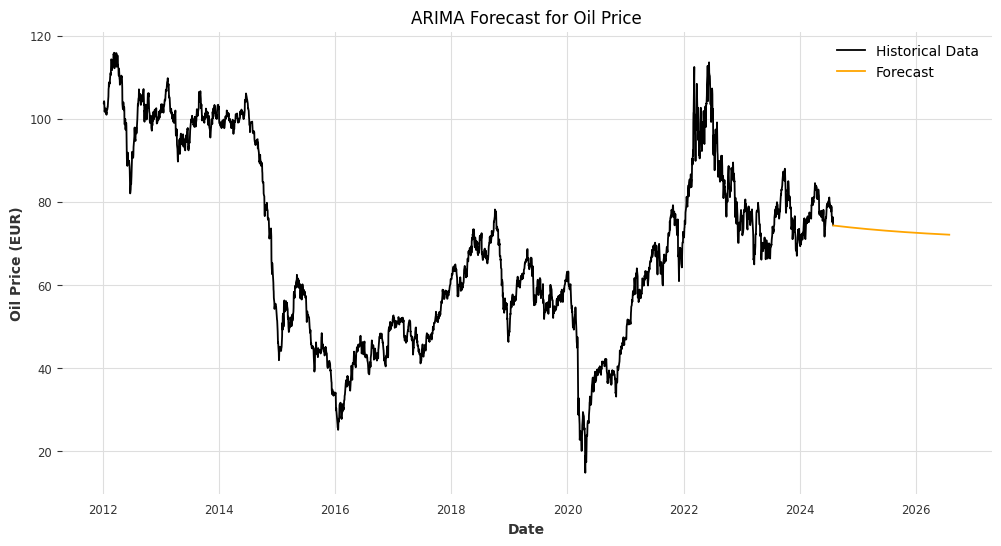

In [90]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")  # Ignore warnings for a cleaner output

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load target data
train_df = load_and_prepare_data('../../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df.csv')

# Concatenate the train and test data
oil_price_df = pd.concat([train_df, test_df])
oil_price_df = oil_price_df[['Date', 'Oil_price (EUR)']].rename(columns={'Date': 'ds', 'Oil_price (EUR)': 'y'})

# Set the Date as the index
oil_price_df.set_index('ds', inplace=True)

# Define the parameter grid for p, d, q
p = range(0, 4)  # Autoregressive part
d = range(0, 2)  # Differencing part
q = range(0, 4)  # Moving average part
param_grid = list(product(p, d, q))

# Perform grid search to find the best parameters
best_rmse = float("inf")
best_order = None
for order in param_grid:
    try:
        model = ARIMA(oil_price_df['y'], order=order)
        model_fit = model.fit()
        # Forecast within sample (for tuning)
        y_pred = model_fit.predict(start=0, end=len(oil_price_df)-1)
        rmse = np.sqrt(mean_squared_error(oil_price_df['y'], y_pred))
        
        # Keep track of best parameters
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
    except:
        continue

print(f"Best ARIMA parameters: {best_order} with RMSE: {best_rmse}")

# Fit the model with the best parameters on the entire dataset
best_model = ARIMA(oil_price_df['y'], order=best_order)
best_model_fit = best_model.fit()

# Forecast into the future
forecast_steps = 730  # Forecast for two years ahead (assuming daily frequency)
forecast = best_model_fit.forecast(steps=forecast_steps)

# Create a date index for future predictions
last_date = oil_price_df.index[-1]
future_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='D')[1:]

# Prepare forecast DataFrame
forecast_df = pd.DataFrame({'ds': future_dates, 'yhat': forecast})

# Plot the historical and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(oil_price_df.index, oil_price_df['y'], label='Historical Data')
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast', color='orange')
plt.title('ARIMA Forecast for Oil Price')
plt.xlabel('Date')
plt.ylabel('Oil Price (EUR)')
plt.legend()
plt.show()
